# Probability of Default Model using ValidMind

- Step 1: Connect Notebook to ValidMind Project
- Step 2: Import Raw Data
- Step 3: Data Description on Raw Data
- Step 4: Data Preprocessing
- Step 5: Data Description on Preprocessed Data 
- Step 6: Univariate Analysis
- Step 7: Multivariate Analysis
- Step 8: Model Training 

## Step 1: Connect Notebook to ValidMind Project

#### Import Libraries

In [1]:
# Load API key and secret from environment variables
%load_ext dotenv
%dotenv .env

import zipfile
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, precision_recall_curve, auc
from sklearn.feature_selection import f_classif
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.stats import chi2_contingency
%matplotlib inline

#### Connect Notebook to ValidMind Project

In [2]:
import validmind as vm

vm.init(
  api_host = "http://localhost:3000/api/v1/tracking",
  api_key = "2494c3838f48efe590d531bfe225d90b",
  api_secret = "4f692f8161f128414fef542cab2a4e74834c75d01b3a8e088a1834f2afcfe838",
  project = "cliwzqjgv00001fy6869rlav9"
)

2023-06-22 21:29:00,080 - INFO - api_client - Connected to ValidMind. Project: [3] PD Model - Initial Validation (cliwzqjgv00001fy6869rlav9)


## Step 2: Import Raw Data

#### Import Lending Club Dataset

In [3]:
# Specify the path to the zip file
# filepath = '/Users/juanvalidmind/Dev/datasets/lending club/data_2007_2014/loan_data_2007_2014.csv'
filepath = '/Users/juanvalidmind/Dev/datasets/lending club/data_2007_2011/lending_club_loan_data_2007_2011.csv'
df = pd.read_csv(filepath)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Columns: 111 entries, id to total_il_high_credit_limit
dtypes: float64(74), int64(13), object(24)
memory usage: 33.6+ MB


/var/folders/tn/rbr74q892k13m82y37y396h40000gn/T/ipykernel_45879/2449495096.py:4: DtypeWarning: Columns (47) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filepath)


## Step 3: Data Description

### Variable Description 

In [4]:
from validmind.vm_models.test_context import TestContext
from validmind.data_validation.metrics import TabularDescriptionTables

vm_df = vm.init_dataset(dataset=df)
test_context = TestContext(dataset=vm_df)
metric = TabularDescriptionTables(test_context)
metric.run()
metric.result.show()

2023-06-22 21:29:00,570 - INFO - client - Pandas dataset detected. Initializing VM Dataset instance...
2023-06-22 21:29:00,570 - INFO - dataset - Inferring dataset types...


### Identify Missing Values

In [5]:
from validmind.tests.data_validation.MissingValues import MissingValues
metric = MissingValues(test_context)
metric.run()
metric.result.show()

In [6]:
#from validmind.tests.data_validation.ClassImbalance import ClassImbalance

#vm_df_train = vm.init_dataset(dataset=df_train,
#                        target_column = target_column)
#test_context = TestContext(dataset=vm_df_train)
#metric = ClassImbalance(test_context)
#metric.run()
#metric.result.show()

## Step 4: Data Preparation

### Identify Target Variable

**Definition of Default**

We categorizing `Fully Paid` loans as "default = 0" and `Charged Off` loans as "default = 1". This binary classification is suitable for developing a credit scorecard, as it enables distinction between applicants likely to fulfill their credit obligations (low risk) and those likely to fail (high risk). 

Loans with `Current` status, which represents ongoing loans with an unresolved outcome, should be excluded from the model, as their final repayment status is still unknown and thus not suitable for a retrospective risk analysis.


**Add `default` Variable**

In [7]:
def add_target_column(df, target_column):
    # Assuming the column name is 'loan_status'
    df[target_column] = df['loan_status'].apply(lambda x: 0 if x == "Fully Paid" else 1 if x == "Charged Off" else 'Current')
    # Remove rows where the target column is 'Current'
    df = df[df[target_column] != 'Current']
    return df

In [8]:
target_column = 'default'
df_prep = add_target_column(df, target_column)

### Remove Unused Variables

Remove all the **Demographic** and **Customer Behavioural** features which is of no use for default analysis for credit approval.

In [9]:
unused_variables = ["id", "member_id", "funded_amnt", "emp_title", "pymnt_plan", "url", "desc",
                    "title", "zip_code", "delinq_2yrs", "mths_since_last_delinq", "mths_since_last_record",
                    "revol_bal", "initial_list_status", "out_prncp", "out_prncp_inv", "total_pymnt",
                    "total_pymnt_inv", "total_rec_prncp", "total_rec_int", "total_rec_late_fee", "recoveries",
                    "collection_recovery_fee", "last_pymnt_d", "last_pymnt_amnt", "next_pymnt_d", "last_credit_pull_d",
                    "collections_12_mths_ex_med", "policy_code", "acc_now_delinq", "application_type", "addr_state",
                    "pub_rec_bankruptcies", "chargeoff_within_12_mths", "tax_liens", "delinq_amnt"]
df_prep = df_prep.drop(columns=unused_variables)

### Remove Variables with Large Number of Missing Values

In [10]:
def variables_with_min_missing(df, min_missing_percentage):
    # Calculate the percentage of missing values in each column
    missing_percentages = df.isnull().mean() * 100

    # Get the variables where the percentage of missing values is greater than the specified minimum
    variables_to_drop = missing_percentages[missing_percentages > min_missing_percentage].index.tolist()

    # Also add any columns where all values are missing
    variables_to_drop.extend(df.columns[df.isnull().all()].tolist())

    # Remove duplicates (if any)
    variables_to_drop = list(set(variables_to_drop))

    return variables_to_drop


In [11]:
min_missing_count = 80
variables_to_drop = variables_with_min_missing(df_prep, min_missing_count)
df_prep.drop(columns=variables_to_drop, axis=1, inplace=True)

In [12]:
df_prep.dropna(axis=0, subset=["emp_length"], inplace=True)
df_prep.dropna(axis=0, subset=["revol_util"], inplace=True)

#### Data Description after Preparation

In [13]:
vm_df_prep = vm.init_dataset(dataset=df_prep)
test_context = TestContext(dataset=vm_df_prep)
metric = TabularDescriptionTables(test_context)
metric.run()
metric.result.show()

2023-06-22 21:29:01,771 - INFO - client - Pandas dataset detected. Initializing VM Dataset instance...
2023-06-22 21:29:01,772 - INFO - dataset - Inferring dataset types...


In [14]:
# Remove the rows with loan_status as "Current"
# df_prep = df_prep[df_prep["loan_status"].apply(lambda x: False if x == "Current" else True)]

# Update loan_status as Fully Paid to 0 and Charged Off to 1
#df_no_current["loan_status"] = df_no_current["loan_status"].apply(lambda x: 0 if x == "Fully Paid" else 1)

# Convert 'emp_length' to string type
#df_no_current["emp_length"] = df_no_current["emp_length"].astype(str)

# Update emp_length feature with continuous values as int
# where (< 1 year) is assumed as 0 and 10+ years is assumed as 10 and rest are stored as their magnitude
#df_no_current["emp_length"] = pd.to_numeric(df_no_current["emp_length"].apply(lambda x: 0 if "<" in x else (x.split('+')[0] if "+" in x else x.split()[0])))

# Look through the purpose value counts
#loan_purpose_values = df_no_current["purpose"].value_counts() * 100 / df_no_current.shape[0]

# Remove rows with less than 1% of value counts in particular purpose 
#loan_purpose_delete = loan_purpose_values[loan_purpose_values < 1].index.values
#df_processed = df_no_current[[False if p in loan_purpose_delete else True for p in df_no_current["purpose"]]]

# Update int_rate, revol_util without % sign and as numeric type
#df_processed["int_rate"] = pd.to_numeric(df_processed["int_rate"].apply(lambda x:x.split('%')[0]))
#df_processed["revol_util"] = pd.to_numeric(df_processed["revol_util"].apply(lambda x:x.split('%')[0]))


## Step 5: Data Sampling 

We employ stratified sampling to create our training and testing sets. Stratified sampling is particularly important in this context. When the `stratify = y` parameter is set, it ensures that the distribution of the target variable (`y`) in the test set is the same as that in the original dataset. 

This is crucial for maintaining a consistent representation of the target variable classes, especially important in scenarios where the classes are imbalanced, which is often the case in credit risk scorecards.

In [15]:
# Split data into train and test 
X = df_prep.drop(target_column, axis = 1)
y = df_prep[target_column]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, 
                                                    random_state = 42, stratify = y)

# Concatenate X_train with y_train to form df_train
df_train = pd.concat([X_train, y_train], axis=1)

# Concatenate X_test with y_test to form df_test
df_test = pd.concat([X_test, y_test], axis=1)

## Step 6: Data Cleaning 

We perform data cleaning after splitting the data into training and testing sets to prevent data leakage, maintain the test set's independence, and avoid overfitting. Data leakage can occur when information from the test set influences the training set, leading to overly optimistic performance. 

Cleaning data separately ensures the test set acts as unseen data, mimicking real-world scenarios more accurately. It also helps to prevent the model from overfitting to the training data's specific characteristics. However, the same cleaning steps should be consistently applied to both training and test data, often facilitated by using saved parameters from the training data or employing pipelines.

### Clean Training Data

In [16]:
def clean_dates(df, column):
    """
    Convert date columns to datetime format.

    Parameters:
    df (pandas.DataFrame): DataFrame to be processed.
    column (str): Name of the date column to be processed.
    """
    df[column] = pd.to_datetime(df[column], format = "%b-%y")


In [17]:
def clean_int_rate(df, column):
    """
    Clean interest rate column. Remove the '%' sign and convert to numeric.

    Parameters:
    df (pandas.DataFrame): DataFrame to be processed.
    column (str): Name of the interest rate column to be cleaned.
    """
    df[column] = df[column].str.replace('%', '')
    df[column] = pd.to_numeric(df[column])

In [18]:
import re

def clean_emp_length(df, column):
    df[column] = df[column].replace('n/a', np.nan)
    df[column] = df[column].str.replace('< 1 year', str(0))
    df[column] = df[column].apply(lambda x: re.sub('\D', '', str(x)))
    df[column] = pd.to_numeric(df[column])
    df[column].fillna(value = 0, inplace=True)

In [19]:
# function to remove 'months' string from the 'term' column and convert it to numeric
def clean_loan_term(df, column):
    df[column] = pd.to_numeric(df[column].str.replace(' months', ''))

In [20]:
clean_dates(df_train, 'earliest_cr_line')
clean_dates(df_train, 'issue_d')
clean_int_rate(df_train, 'int_rate')
clean_emp_length(df_train, 'emp_length')
clean_loan_term(df_train, 'term')

### Clean Test Data

In [21]:
clean_dates(df_test, 'earliest_cr_line')
clean_dates(df_test, 'issue_d')
clean_int_rate(df_test, 'int_rate')
clean_emp_length(df_test, 'emp_length')
clean_loan_term(df_test, 'term')

### Data Description after Cleaning

**Train Data Description**

In [22]:
vm_df_train = vm.init_dataset(dataset=df_train)
test_context = TestContext(dataset=vm_df_train)
metric = TabularDescriptionTables(test_context)
metric.run()
metric.result.show()

2023-06-22 21:29:02,356 - INFO - client - Pandas dataset detected. Initializing VM Dataset instance...
2023-06-22 21:29:02,356 - INFO - dataset - Inferring dataset types...


**Test Data Description**

In [23]:
vm_df_test = vm.init_dataset(dataset=df_test)
test_context = TestContext(dataset=vm_df_test)
metric = TabularDescriptionTables(test_context)
metric.run()
metric.result.show()

2023-06-22 21:29:02,541 - INFO - client - Pandas dataset detected. Initializing VM Dataset instance...
2023-06-22 21:29:02,542 - INFO - dataset - Inferring dataset types...


## Step 6: Feature Selection

In [24]:
categorical_features = ['grade', 'home_ownership', 'verification_status', 'purpose']
numerical_features = ['loan_amnt', 'funded_amnt_inv', 'int_rate', 'installment', 'emp_length', 'annual_inc', 'dti', 'inq_last_6mths', 'open_acc', 'total_acc']
date_time_columns = ['issue_d', 'earliest_cr_line']
selected_columns = categorical_features + numerical_features + date_time_columns + [target_column]
 
# Select these columns from X_train and X_test
df_train = df_train[selected_columns]
df_test = df_test[selected_columns]

## Step 7: Univariate Analysis

### Histograms of Numerical Features

In [25]:
from validmind.data_validation.metrics import TabularNumericalHistograms

vm_df_train = vm.init_dataset(dataset=df_train)
test_context = TestContext(dataset=vm_df_train)
metric = TabularNumericalHistograms(test_context)
metric.run()
metric.result.show()

2023-06-22 21:29:02,677 - INFO - client - Pandas dataset detected. Initializing VM Dataset instance...
2023-06-22 21:29:02,678 - INFO - dataset - Inferring dataset types...


### High Cardinality of Categorical Features

In [26]:
from validmind.tests.data_validation.HighCardinality import HighCardinality
metric = HighCardinality(test_context)
metric.run()
metric.result.show()

### Bar Plots of Categorical Features

In [27]:
from validmind.data_validation.metrics import TabularCategoricalBarPlots
metric = TabularCategoricalBarPlots(test_context)
metric.run()
metric.result.show()

### Histogram of Datetime Variables

In [28]:
from validmind.data_validation.metrics import TabularDateTimeHistograms
metric = TabularDateTimeHistograms(test_context)
metric.run()
metric.result.show()

### Default Ratios by Categorical Feature

In [29]:
from validmind.data_validation.metrics import DefaultRatioBarPlots

# Configure the metric
params = {
    "default_column": target_column,
    "columns": None
}

metric = DefaultRatioBarPlots(test_context, params=params)
metric.run()
metric.result.show()

The column default is correct and contains only 1 and 0.
['grade', 'home_ownership', 'verification_status', 'purpose']


## Step 7: Multivariate Analysis

### Bivariate Bar Plots

2023-06-22 21:29:36,246 - INFO - client - Pandas dataset detected. Initializing VM Dataset instance...
2023-06-22 21:29:36,247 - INFO - dataset - Inferring dataset types...


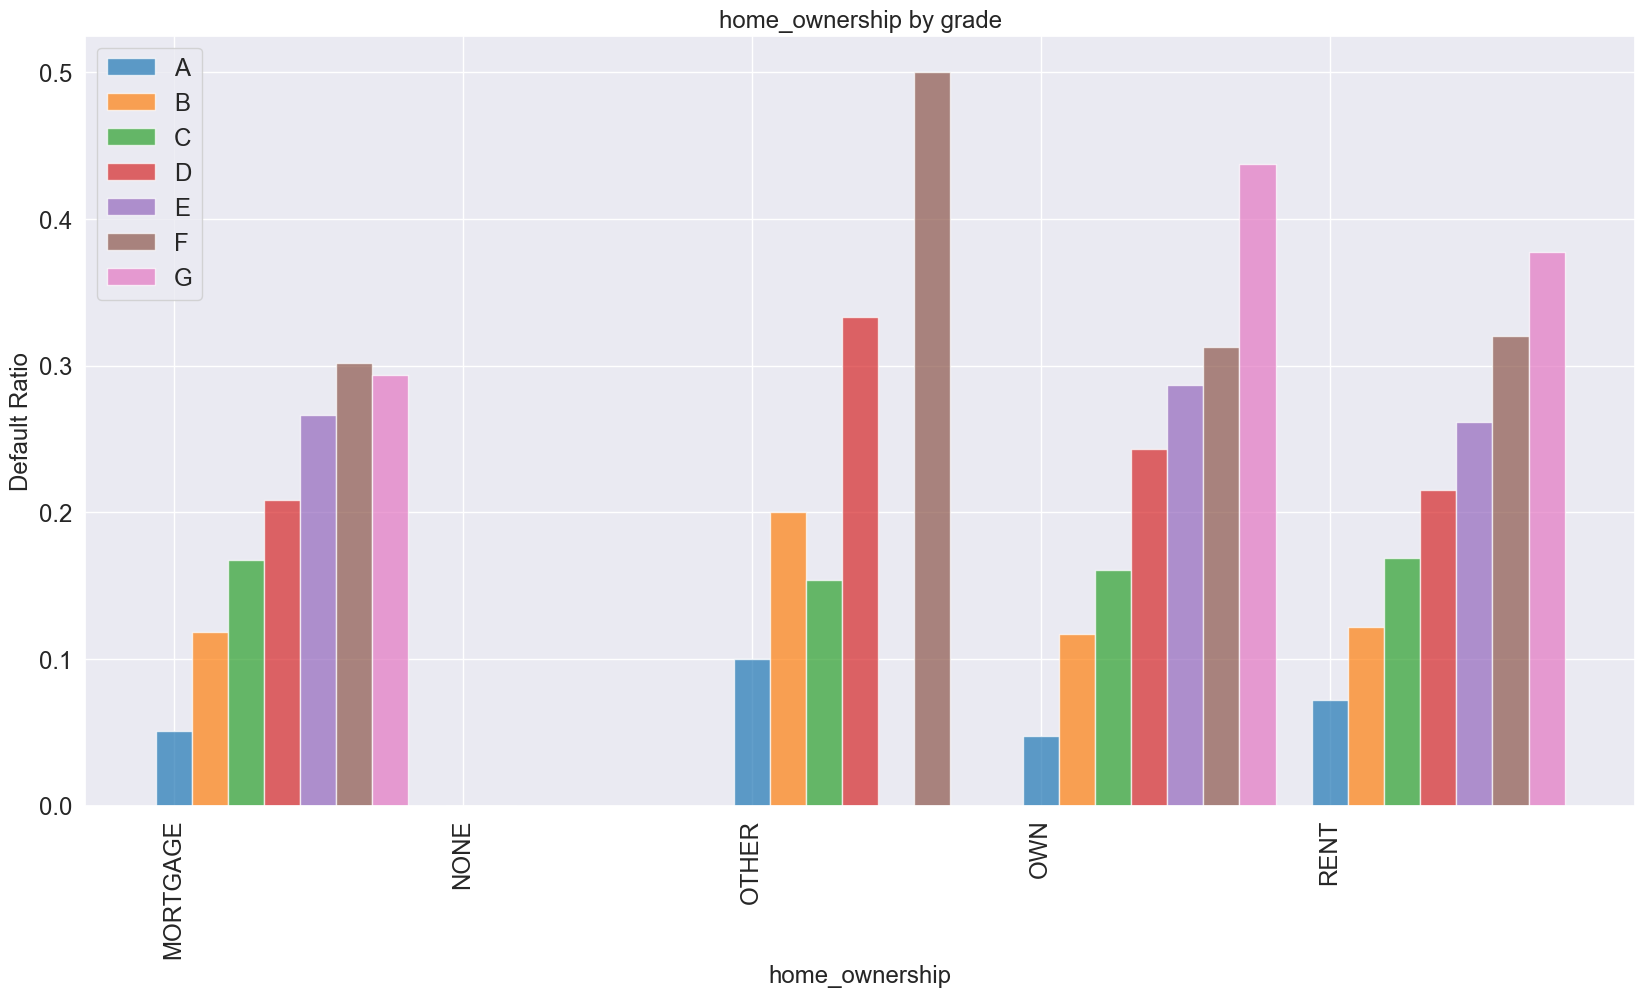

<Figure size 2000x1000 with 0 Axes>

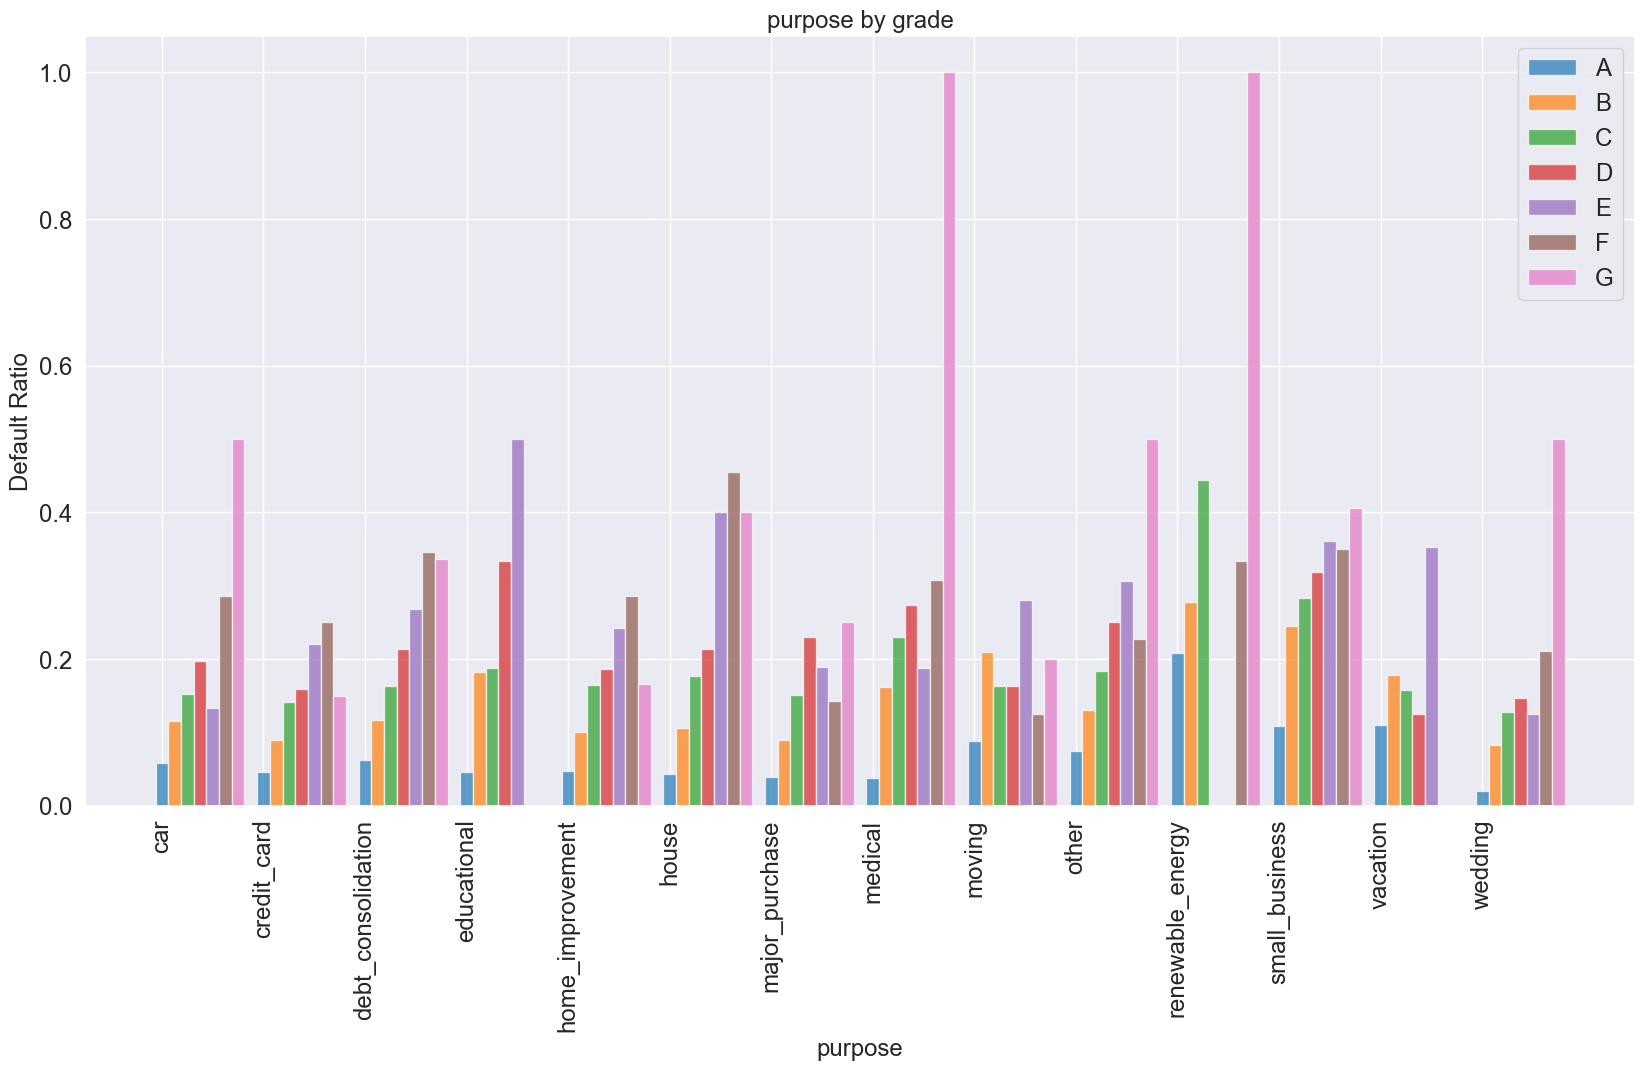

<Figure size 2000x1000 with 0 Axes>

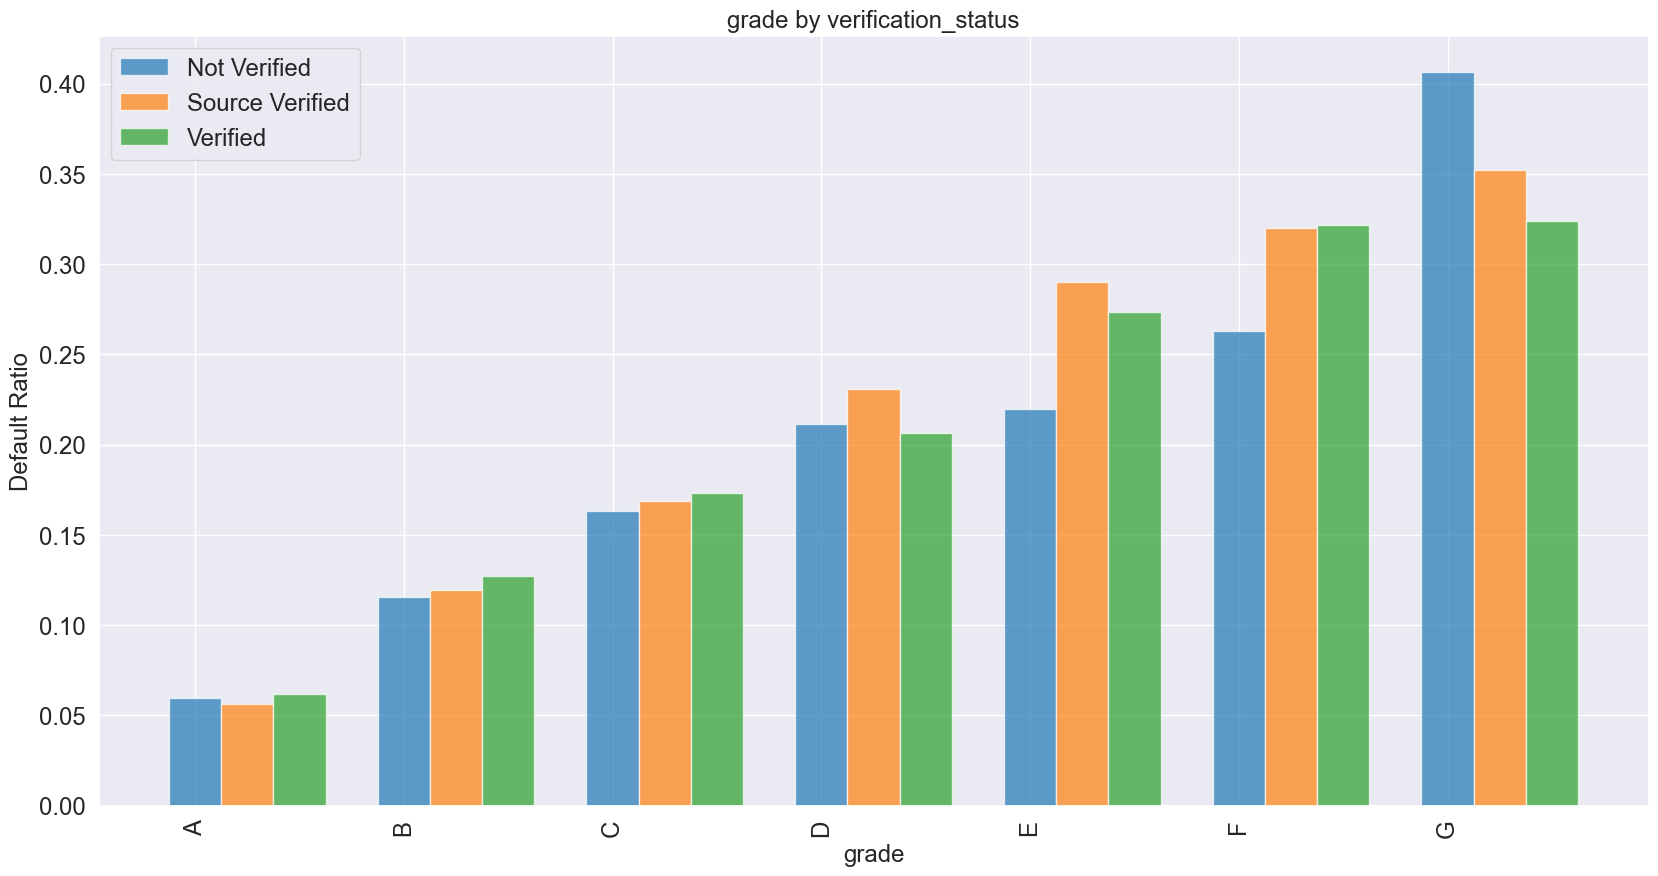

TestPlanMetricResult(result_id="bivariate_features_bar_plots", metric, figures)

In [30]:
from validmind.tests.data_validation.BivariateFeaturesBarPlots import BivariateFeaturesBarPlots

# Configure the metric
features_pairs = {'home_ownership': 'grade', 
                  'purpose': 'grade',
                  'grade': 'verification_status'}

params = {
    "features_pairs": features_pairs,
}

# Pass target column to validmind dataset
vm_df_train = vm.init_dataset(dataset=df_train, target_column=target_column)
test_context = TestContext(dataset=vm_df_train)
metric = BivariateFeaturesBarPlots(test_context, params=params)
metric.run()

### Scatter Plots by Default Status

In [ ]:
from validmind.tests.data_validation.BivariateScatterPlots import BivariateScatterPlots

variable_pairs = {'int_rate': 'annual_inc', 
                  'funded_amnt_inv': 'dti', 
                  'annual_inc': 'funded_amnt_inv',
                  'loan_amnt': 'int_rate',
                  'int_rate': 'annual_inc',
                  'earliest_cr_line': 'int_rate'}

params = {
    "variable_pairs": variable_pairs,
    "status_filter": None
}

metric = BivariateScatterPlots(test_context, params=params)
metric.run()

## Step 7: Feature Engineering 

#### Add Dummy Variables

In [ ]:
def add_dummy_variables(df, columns_list):
    """
    Generate dummy variables for specified columns in the DataFrame,
    concatenate them with the original DataFrame.

    Parameters:
    df (pandas.DataFrame): DataFrame to be processed.
    columns_list (list): List of column names to be processed.
    """
    for column in columns_list:
        dummies = pd.get_dummies(df[column], prefix=column + ":", drop_first=False)
        df = pd.concat([df, dummies], axis=1)
    return df


In [ ]:
df_train = add_dummy_variables(df_train, ['grade', 'home_ownership', 'verification_status', 'purpose'])
df_test = add_dummy_variables(df_test, ['grade', 'home_ownership', 'verification_status', 'purpose'])

In [ ]:
# Adjust the X_test DataFrame to match the column structure of the X_train DataFrame
df_test = df_test.reindex(labels=df_train.columns, axis=1, fill_value=0)

#### Weight of Evidence (WoE) Binning

In [ ]:
def calculate_woe_iv(df, target_column, features=None):
    """
    Calculate the Weight of Evidence (WoE) and Information Value (IV)
    of categorical features.
    
    Parameters:
    df (pandas.DataFrame): DataFrame to be processed. It should contain the target column.
    target_column (str): Name of the target column in the DataFrame.
    features (list, optional): List of feature names for which WoE and IV is to be calculated. 
                               If None, all features in df will be used.
    
    Returns:
    pandas.DataFrame: A DataFrame with the WoE and IV for each category of the feature(s).
    """
    
    # If no specific features specified, use all columns in the DataFrame
    if features is None:
        features = df.drop(target_column, axis=1).columns.tolist()

    # Create a dataframe to store WoE and IV values
    master = []
    
    for feature in features:
        lst = []
        
        # For each unique category in the feature
        for val in df[feature].unique():
            lst.append({
                'Variable': feature,
                'Value': val,
                'All': df[df[feature] == val].count()[feature],
                'Good': df[(df[feature] == val) & (df[target_column] == 0)].count()[feature],
                'Bad': df[(df[feature] == val) & (df[target_column] == 1)].count()[feature]
            })
            
        dset = pd.DataFrame(lst)
        
        # Calculate WoE and IV
        dset['Distr_Good'] = dset['Good'] / dset['Good'].sum()
        dset['Distr_Bad'] = dset['Bad'] / dset['Bad'].sum()
        dset['WoE'] = np.log(dset['Distr_Good'] / dset['Distr_Bad'])
        dset['IV'] = (dset['Distr_Good'] - dset['Distr_Bad']) * dset['WoE']

        master.append(dset)
    
    master_dset = pd.concat(master, ignore_index=True)
    
    return master_dset.sort_values(by=['Variable', 'WoE'])

In [ ]:
categorical_woe_iv_df = calculate_woe_iv(df_train, target_column, categorical_features)
display(categorical_woe_iv_df)

Binning numerical features for WOE and IV calculations. 

In [ ]:
def bin_numerical_variables(df, columns_list, bins=5, labels=None):
    """
    Bin the specified numerical columns into categories.
    
    Parameters:
    df (pandas.DataFrame): DataFrame to be processed.
    columns_list (list): List of column names to be processed.
    bins (int or sequence, optional): Number of bins to create, or a sequence representing the bins.
    labels (list, optional): Labels for the bins. Must be the same length as the resulting bins.

    Returns:
    pandas.DataFrame: A DataFrame with the new binned columns.
    """
    df_copy = df.copy()
    
    for column in columns_list:
        if pd.api.types.is_numeric_dtype(df[column]):
            # Convert the bin intervals to strings
            df_copy[column+'_bin'] = pd.cut(df[column], bins=bins, labels=labels).astype(str)
        else:
            raise ValueError(f"Column {column} is not numerical.")
        
    return df_copy


In [ ]:
numerical_features = ['loan_amnt', 'funded_amnt_inv', 'int_rate', 'installment', 'emp_length', 'annual_inc', 'dti', 'inq_last_6mths', 'open_acc', 'total_acc']
df_train = bin_numerical_variables(df_train, numerical_features)

# Create a list of binned features
binned_features = [f+'_bin' for f in numerical_features]

# Calculate WoE and IV for the binned features
woe_iv_df_numerical = calculate_woe_iv(df_train, target_column, binned_features)

# Display the resulting DataFrame
display(woe_iv_df_numerical)

In [ ]:
vm_df_train = vm.init_dataset(dataset=df_train)
test_context = TestContext(dataset=vm_df_train)
metric = TabularDescriptionTables(test_context)
metric.run()
metric.result.show()

## Step 7: Multivariate Analysis

**Scatter Plots**

In [ ]:
from validmind.tests.data_validation.BivariateScatterPlots import BivariateScatterPlots

variable_pairs = {'int_rate': 'annual_inc', 
                  'funded_amnt_inv': 'dti', 
                  'annual_inc': 'funded_amnt_inv',
                  'loan_amnt': 'int_rate',
                  'int_rate': 'annual_inc',
                  'earliest_cr_line': 'int_rate'}

params = {
    "variable_pairs": variable_pairs,
    "status_filter": None
}

metric = BivariateScatterPlots(test_context, params=params)
metric.run()

**Bivariate Histograms**

In [ ]:
from validmind.tests.data_validation.BivariateHistograms import BivariateHistograms

variable_pairs = {'int_rate': 'annual_inc', 
                  'funded_amnt_inv': 'dti', 
                  'annual_inc': 'funded_amnt_inv',
                  'loan_amnt': 'int_rate',
                  'int_rate': 'annual_inc',
                  'earliest_cr_line': 'int_rate'}


params = {
    "variable_pairs": variable_pairs,
    "status_var": 'loan_status', 
    "status_filter": None
}

metric = BivariateHistograms(test_context, params=params)
metric.run()

#### Multivariate Analysis 

**Pearson Correlation Matrix**

In [ ]:
from validmind.tests.data_validation.PearsonCorrelationMatrix import PearsonCorrelationMatrix

metric = PearsonCorrelationMatrix(test_context)
metric.run()
metric.result.show()



## Step 8: Model Training

In [ ]:
df_multivariate.info()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# First, we define the preprocessing steps
numeric_features = ['pub_rec', 'revol_util', 'funded_amnt_inv', 'int_rate', 'dti', 'annual_inc', 'loan_amnt', 'earliest_cr_line']
categorical_features = ['term', 'grade', 'purpose', 'annual_inc_range', 'loan_amnt_range']

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression(solver='lbfgs', max_iter=1000))])



# Train the model
clf.fit(X_train, y_train)

# We can now evaluate on the test set
print("model score: %.3f" % clf.score(X_test, y_test))


In [ ]:
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
import pandas as pd

# First, we define the preprocessing steps
numeric_features = ['pub_rec', 'revol_util', 'funded_amnt_inv', 'int_rate', 'dti', 'annual_inc', 'loan_amnt', 'earliest_cr_line']
categorical_features = ['term', 'grade', 'purpose', 'annual_inc_range', 'loan_amnt_range', 'installment']  # Added 'installment'

# Handle categorical features
df_encoded = pd.get_dummies(df_multivariate, columns=categorical_features)

# Split the data
X = df_encoded.drop('loan_status', axis=1)
y = df_encoded['loan_status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Add a constant to the independent values
X_train = sm.add_constant(X_train)

# Define the model
glm_model_fit = sm.GLM(y_train, X_train, family=sm.families.Binomial())

# Fit the model
results = glm_model_fit.fit()

# Print the summary
print(results.summary())

# Evaluate on the test set
X_test = sm.add_constant(X_test)  # Adding a constant to the test data
y_pred = results.predict(X_test)

# You can then further analyze y_pred to measure model performance on the test set.

Scale variable X. 

In [ ]:
import statsmodels.api as sm
from sklearn.preprocessing import scale

# Scale your variables
X_scaled = scale(X)

# Add a constant to the independent values
X_scaled = sm.add_constant(X_scaled)

# Define the model
model = sm.GLM(y, X_scaled, family=sm.families.Binomial())

# Fit the model
results = model.fit()

# Print the summary
print(results.summary())


#### ValidMind Models 

In [ ]:
# Initialize training and testing datasets for model A
vm_train_ds = vm.init_dataset(dataset=X_train, type="generic", target_column='loan_status')
vm_test_ds = vm.init_dataset(dataset=X_test, type="generic", target_column='loan_status')

# Initialize model A
vm_model_A = vm.init_model(
    model = glm_model_fit, 
    train_ds=vm_train_ds, 
    test_ds=vm_test_ds)